In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_from_disk
from tqdm.auto import tqdm
import gc
from PIL import Image
import torch.nn.functional as F
import torchvision.models as models
import matplotlib.pyplot as plt

In [2]:
# Data Preprocessing
# Load the remapped balanced dataset
dataset_path = "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/data/remapped_dataset"
dataset = load_from_disk(dataset_path)
print("Remapped dataset loaded from disk")
print(f"Dataset size: {len(dataset)} images.")

split_ds = dataset.train_test_split(test_size=0.2, seed=42)
test_dataset = split_ds["test"]
train_val_dataset = split_ds["train"]
split_remaining = train_val_dataset.train_test_split(test_size=0.125, seed=42)
train_dataset = split_remaining["train"]
val_dataset = split_remaining["test"]

print(f"Train dataset size: {len(train_dataset)} images")
print(f"Validation dataset size: {len(val_dataset)} images")
print(f"Test dataset size: {len(test_dataset)} images")

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

def process_image(image):
    """
    Receives a raw PIL image, applies the transformation, and ensures the output is 224x224.
    """
    # Apply transforms. This converts the PIL image to a tensor of shape [3, 224, 224]
    img_tensor = train_transforms(image)
    # Double-check that the output is the desired shape
    if img_tensor.shape[-2:] != (224, 224):
        img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
    return img_tensor

def custom_collate_fn(batch):
    """
    Custom collate that:
      - Processes the raw PIL image using process_image.
      - Converts "genre" and "style" to tensors.
    """
    images = [process_image(item["image"]) for item in batch]
    genres = torch.tensor([item["genre"] for item in batch])
    styles = torch.tensor([item["style"] for item in batch])
    return {"image": torch.stack(images), "genre": genres, "style": styles}

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=custom_collate_fn)

print("DataLoaders are ready")


Remapped dataset loaded from disk
Dataset size: 17061 images.
Train dataset size: 11942 images
Validation dataset size: 1706 images
Test dataset size: 3413 images
DataLoaders are ready


In [3]:
class ResNet50MultiHead(nn.Module):
    def __init__(self, num_genres, num_styles):
        super(ResNet50MultiHead, self).__init__()
        # Load pretrained ResNet50
        self.resnet = models.resnet50(pretrained=True)
        # Freeze all ResNet50 parameters
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Remove the original final fully connected layer
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Identity()
        
        # Define separate classifier heads for genre and style
        self.genre_classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_genres)
        )
        self.style_classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_styles)
        )
        
    def forward(self, x):
        features = self.resnet(x)  # Extract features using ResNet50
        genre_logits = self.genre_classifier(features)
        style_logits = self.style_classifier(features)
        return genre_logits, style_logits

# Determine the number of classes from the dataset
num_genres = len(set(dataset["genre"]))
num_styles = len(set(dataset["style"]))
print(f"Number of genre classes: {num_genres}")
print(f"Number of style classes: {num_styles}")


Number of genre classes: 11
Number of style classes: 11


In [4]:
# Model Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet50MultiHead(num_genres, num_styles).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


C:\Users\wassi\Documents\Fanshawe\S2\pytorch\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wassi\Documents\Fanshawe\S2\pytorch\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\wassi\Documents\Fanshawe\S2\pytorch\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [5]:
# Training, Validation, and Testing
num_epochs = 10

# Lists to store history
def compute_metrics(genre_logits, style_logits, genre_labels, style_labels):
    pred_genre = torch.argmax(genre_logits, dim=1)
    pred_style = torch.argmax(style_logits, dim=1)
    acc_genre = (pred_genre == genre_labels).float().mean().item()
    acc_style = (pred_style == style_labels).float().mean().item()
    joint_acc = ((pred_genre == genre_labels) & (pred_style == style_labels)).float().mean().item()
    return acc_genre, acc_style, joint_acc

history = {
    "train_loss": [],
    "train_genre_acc": [],
    "train_style_acc": [],
    "train_joint_acc": [],
    "val_loss": [],
    "val_genre_acc": [],
    "val_style_acc": [],
    "val_joint_acc": []
}

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_acc_genre = 0.0
    train_acc_style = 0.0
    train_joint_acc = 0.0
    total_train = 0
    
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        images = batch["image"].to(device)
        genre_labels = batch["genre"].to(device)
        style_labels = batch["style"].to(device)
        
        optimizer.zero_grad()
        genre_logits, style_logits = model(images)
        loss = criterion(genre_logits, genre_labels) + criterion(style_logits, style_labels)
        loss.backward()
        optimizer.step()
        
        batch_size = images.size(0)
        train_loss += loss.item() * batch_size
        acc_g, acc_s, joint = compute_metrics(genre_logits, style_logits, genre_labels, style_labels)
        train_acc_genre += acc_g * batch_size
        train_acc_style += acc_s * batch_size
        train_joint_acc += joint * batch_size
        total_train += batch_size
    
    avg_train_loss = train_loss / total_train
    avg_train_acc_genre = train_acc_genre / total_train
    avg_train_acc_style = train_acc_style / total_train
    avg_train_joint_acc = train_joint_acc / total_train

    # Save training metrics
    history["train_loss"].append(avg_train_loss)
    history["train_genre_acc"].append(avg_train_acc_genre)
    history["train_style_acc"].append(avg_train_acc_style)
    history["train_joint_acc"].append(avg_train_joint_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_acc_genre = 0.0
    val_acc_style = 0.0
    val_joint_acc = 0.0
    total_val = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False):
            images = batch["image"].to(device)
            genre_labels = batch["genre"].to(device)
            style_labels = batch["style"].to(device)
            
            genre_logits, style_logits = model(images)
            loss = criterion(genre_logits, genre_labels) + criterion(style_logits, style_labels)
            batch_size = images.size(0)
            val_loss += loss.item() * batch_size
            acc_g, acc_s, joint = compute_metrics(genre_logits, style_logits, genre_labels, style_labels)
            val_acc_genre += acc_g * batch_size
            val_acc_style += acc_s * batch_size
            val_joint_acc += joint * batch_size
            total_val += batch_size

    avg_val_loss = val_loss / total_val
    avg_val_acc_genre = val_acc_genre / total_val
    avg_val_acc_style = val_acc_style / total_val
    avg_val_joint_acc = val_joint_acc / total_val

    # Save validation metrics
    history["val_loss"].append(avg_val_loss)
    history["val_genre_acc"].append(avg_val_acc_genre)
    history["val_style_acc"].append(avg_val_acc_style)
    history["val_joint_acc"].append(avg_val_joint_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {avg_train_loss:.4f}, Genre Acc = {avg_train_acc_genre:.4f}, "
          f"Style Acc = {avg_train_acc_style:.4f}, Joint Acc = {avg_train_joint_acc:.4f}")
    print(f"                  Val   Loss = {avg_val_loss:.4f}, Genre Acc = {avg_val_acc_genre:.4f}, "
          f"Style Acc = {avg_val_acc_style:.4f}, Joint Acc = {avg_val_joint_acc:.4f}")
    
    scheduler.step(avg_val_loss)

print("Training complete")


Training Epoch 1:   0%|          | 0/374 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 1/10: Train Loss = 3.6223, Genre Acc = 0.4423, Style Acc = 0.3219, Joint Acc = 0.1836
                  Val   Loss = 3.2636, Genre Acc = 0.5094, Style Acc = 0.4050, Joint Acc = 0.2579


Training Epoch 2:   0%|          | 0/374 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 2/10: Train Loss = 3.2475, Genre Acc = 0.4997, Style Acc = 0.3935, Joint Acc = 0.2456
                  Val   Loss = 3.1386, Genre Acc = 0.4988, Style Acc = 0.4326, Joint Acc = 0.2468


Training Epoch 3:   0%|          | 0/374 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 3/10: Train Loss = 3.1573, Genre Acc = 0.5127, Style Acc = 0.4192, Joint Acc = 0.2653
                  Val   Loss = 3.1058, Genre Acc = 0.5381, Style Acc = 0.3951, Joint Acc = 0.2649


Training Epoch 4:   0%|          | 0/374 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 4/10: Train Loss = 3.0827, Genre Acc = 0.5198, Style Acc = 0.4311, Joint Acc = 0.2768
                  Val   Loss = 3.0922, Genre Acc = 0.5229, Style Acc = 0.4308, Joint Acc = 0.2872


Training Epoch 5:   0%|          | 0/374 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 5/10: Train Loss = 3.0166, Genre Acc = 0.5297, Style Acc = 0.4458, Joint Acc = 0.2889
                  Val   Loss = 2.9993, Genre Acc = 0.5234, Style Acc = 0.4637, Joint Acc = 0.2855


Training Epoch 6:   0%|          | 0/374 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 6/10: Train Loss = 3.0018, Genre Acc = 0.5338, Style Acc = 0.4490, Joint Acc = 0.2941
                  Val   Loss = 2.9983, Genre Acc = 0.5305, Style Acc = 0.4637, Joint Acc = 0.3025


Training Epoch 7:   0%|          | 0/374 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 7/10: Train Loss = 2.9724, Genre Acc = 0.5371, Style Acc = 0.4593, Joint Acc = 0.3004
                  Val   Loss = 2.9467, Genre Acc = 0.5557, Style Acc = 0.4531, Joint Acc = 0.2995


Training Epoch 8:   0%|          | 0/374 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 8/10: Train Loss = 2.8967, Genre Acc = 0.5485, Style Acc = 0.4694, Joint Acc = 0.3102
                  Val   Loss = 3.0110, Genre Acc = 0.5123, Style Acc = 0.4601, Joint Acc = 0.2884


Training Epoch 9:   0%|          | 0/374 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 9/10: Train Loss = 2.8922, Genre Acc = 0.5464, Style Acc = 0.4678, Joint Acc = 0.3114
                  Val   Loss = 2.8688, Genre Acc = 0.5504, Style Acc = 0.4719, Joint Acc = 0.3253


Training Epoch 10:   0%|          | 0/374 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/54 [00:00<?, ?it/s]

Epoch 10/10: Train Loss = 2.8774, Genre Acc = 0.5498, Style Acc = 0.4687, Joint Acc = 0.3155
                  Val   Loss = 2.8577, Genre Acc = 0.5692, Style Acc = 0.4560, Joint Acc = 0.3042
Training complete


In [6]:
# Test
model.eval()

test_loss = 0.0
test_acc_genre = 0.0
test_acc_style = 0.0
test_joint_acc = 0.0
total_test = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing", leave=False):
        images = batch["image"].to(device)
        genre_labels = batch["genre"].to(device)
        style_labels = batch["style"].to(device)
        
        genre_logits, style_logits = model(images)
        loss = criterion(genre_logits, genre_labels) + criterion(style_logits, style_labels)
        batch_size = images.size(0)
        test_loss += loss.item() * batch_size
        acc_g, acc_s, joint = compute_metrics(genre_logits, style_logits, genre_labels, style_labels)
        test_acc_genre += acc_g * batch_size
        test_acc_style += acc_s * batch_size
        test_joint_acc += joint * batch_size
        total_test += batch_size

avg_test_loss = test_loss / total_test
avg_test_acc_genre = test_acc_genre / total_test
avg_test_acc_style = test_acc_style / total_test
avg_test_joint_acc = test_joint_acc / total_test

print(f"Test Loss = {avg_test_loss:.4f}, Genre Acc = {avg_test_acc_genre:.4f}, "
      f"Style Acc = {avg_test_acc_style:.4f}, Joint Acc = {avg_test_joint_acc:.4f}")

print("Testing complete")


Testing:   0%|          | 0/107 [00:00<?, ?it/s]

Test Loss = 2.8735, Genre Acc = 0.5646, Style Acc = 0.4670, Joint Acc = 0.3065
Testing complete


In [9]:
# Save the model and training history locally
torch.save(model.state_dict(), "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50/resnet50_multihhead.pth")
print("Model saved")

torch.save(history, "C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50/resnet50_training_history.pth")
print("Training history saved")


Model saved
Training history saved


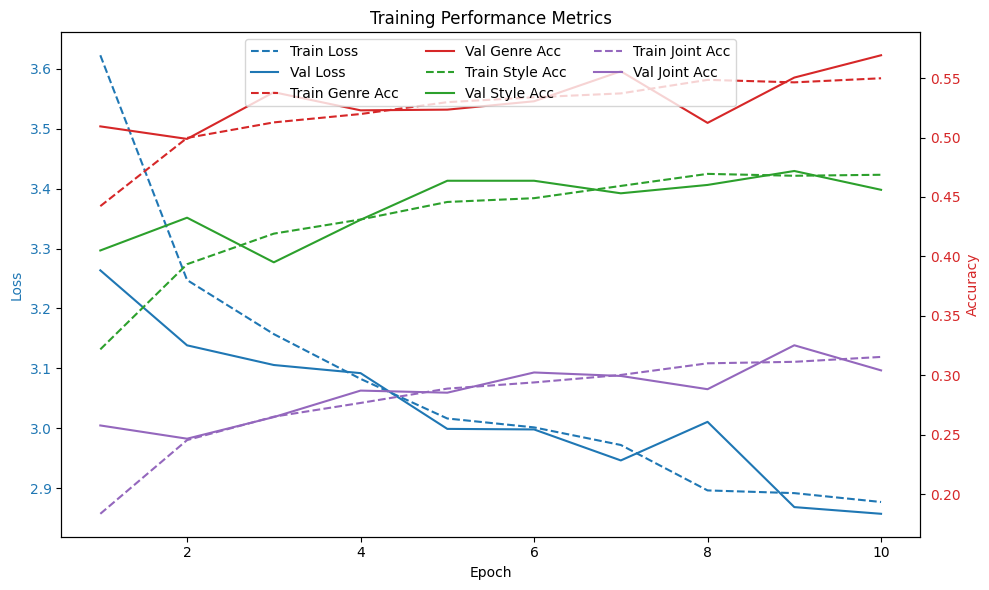

In [11]:
history = torch.load("C:/Users/wassi/Documents/Fanshawe/S2/pytorch/Project/wikiart_classification/models_history/resnet50/resnet50_training_history.pth")

num_epochs = len(history["train_loss"])
epochs = range(1, num_epochs + 1)

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color="tab:blue")
ax1.plot(epochs, history["train_loss"], label="Train Loss", color="tab:blue", linestyle="--")
ax1.plot(epochs, history["val_loss"], label="Val Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color="tab:red")
ax2.plot(epochs, history["train_genre_acc"], label="Train Genre Acc", color="tab:red", linestyle="--")
ax2.plot(epochs, history["val_genre_acc"], label="Val Genre Acc", color="tab:red")
ax2.plot(epochs, history["train_style_acc"], label="Train Style Acc", color="tab:green", linestyle="--")
ax2.plot(epochs, history["val_style_acc"], label="Val Style Acc", color="tab:green")
ax2.plot(epochs, history["train_joint_acc"], label="Train Joint Acc", color="tab:purple", linestyle="--")
ax2.plot(epochs, history["val_joint_acc"], label="Val Joint Acc", color="tab:purple")
ax2.tick_params(axis="y", labelcolor="tab:red")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper center", ncol=3)

plt.title("Training Performance Metrics")
plt.tight_layout()
plt.show()
